<a href="https://colab.research.google.com/github/siddhi5386/Emotion-Recognition-from-brain-EEG-signals-/blob/master/emotion%20recognition%20by%20lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/forrestbao/pyeeg.git
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-bkslg_pj
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-bkslg_pj
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28132 sha256=538e053305f85953c7ff2cead5119992e6971fefe24c6dbdc0b7f23daf309a7f
  Stored in directory: /tmp/pip-ephem-wheel-cache-8cu39kqs/wheels/b0/23/e4/703c908bda656959957029fa145879aa79307b2545a2ef0271
Successfully built pyeeg


In [ ]:
!pip install git+https://github.com/forrestbao/pyeeg.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-hbd9wcq3
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-hbd9wcq3


In [ ]:

import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
#from keras.utils import to_categorical 
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
from tensorflow.keras.optimizers import SGD
#import cv2, numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
os.getcwd()
os.chdir('/content/drive/MyDrive')

In [ ]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] 
band = [4,8,12,16,25,45] 
window_size = 256
step_size = 16 
sample_rate = 128
subjectList = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20']

In [ ]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA
ica = FastICA(n_components=40, random_state=0)
X_transformed = ica.fit_transform(data)
X_transformed.shape


In [ ]:
ica_activity=np.dot(X_transformed,data)
print(ica_activity,ica_activity.shape)

In [ ]:
def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean 
    return centered, mean

In [ ]:
def covariance(x):
    mean = np.mean(x, axis=1, keepdims=True)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n

In [ ]:
def whiten(X):
    # Calculate the covariance matrix
    coVarM = covariance(X) 
    
    # Single value decoposition
    U, S, V = np.linalg.svd(coVarM)
    
    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S)) 
    
    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))
    
    # Project onto whitening matrix
    Xw = np.dot(whiteM, X) 
    
    return Xw, whiteM

In [ ]:
def fastIca(signals,  alpha = 1, thresh=1e-8, iterations=5000):
    m, n = signals.shape

    # Initialize random weights
    W = np.random.rand(m, m)

    for c in range(m):
            w = W[c, :].copy().reshape(m, 1)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            lim = 100
            while ((lim > thresh) & (i < iterations)):

                # Dot product of weight and signal
                ws = np.dot(w.T, signals)

                # Pass w*s into contrast function g
                wg = np.tanh(ws * alpha).T

                # Pass w*s into g prime 
                wg_ = (1 - np.square(np.tanh(ws))) * alpha

                # Update weights
                wNew = (signals * wg.T).mean(axis=1) - wg_.mean() * w.squeeze()

                # Decorrelate weights              
                wNew = wNew - np.dot(np.dot(wNew, W[:c].T), W[:c])
                wNew = wNew / np.sqrt((wNew ** 2).sum())

                # Calculate limit condition
                lim = np.abs(np.abs((wNew * w).sum()) - 1)
                
                # Update weights
                w = wNew
                
                # Update counter
                i += 1

            W[c, :] = w.T
    return W


In [ ]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open("/content/drive/MyDrive/BTP/data_preprocessed_python/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') 
        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] 
                for j in channel:
                    X = data[j][start : start + window_size] 
                    Y = pe.bin_power(X, band, sample_rate) 
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        np.save('/content/drive/MyDrive/BTP/data_preprocessed_python/GRU20P/s' + sub, meta, allow_pickle=True, fix_imports=True)

In [ ]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [ ]:

data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open('/content/drive/MyDrive/BTP/data_preprocessed_python/GRU20P/s' + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 4 == 0:
          data_testing.append(sub[i][0])
          label_testing.append(sub[i][1])
        else:
          data_training.append(sub[i][0])
          label_training.append(sub[i][1])

np.save('/content/drive/MyDrive/BTP/data_preprocessed_python/GRU_Ldata/data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/BTP/data_preprocessed_python/GRU_Ldata/label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save('/content/drive/MyDrive/BTP/data_preprocessed_python/GRU_Ldata/data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/BTP/data_preprocessed_python/GRU_Ldata/label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (292800, 70) (292800, 4)
testing dataset: (97600, 70) (97600, 4)


In [ ]:

with open('/content/drive/MyDrive/BTP/data_preprocessed_python/GRU_Ldata/data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open('/content/drive/MyDrive/BTP/data_preprocessed_python/GRU_Ldata/label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [1]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

In [ ]:
X.shape

(292800, 70)

In [ ]:
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(Z)
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
x_train = np.array(X[:])

In [ ]:

with open('/content/drive/MyDrive/BTP/data_preprocessed_python/GRU_Ldata/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open('/content/drive/MyDrive/BTP/data_preprocessed_python/GRU_Ldata/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [1]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

In [ ]:
x_test = np.array(M[:])

In [ ]:
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(L)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [ ]:
x_train.shape

(292800, 70, 1)

In [ ]:

batch_size = 256
num_classes = 10
epochs = 200
input_shape=(x_train.shape[1], 1)

In [ ]:

print(input_shape)

(70, 1)


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# # compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# # fit the model
# history = model.fit(Xtrain, ytrain, validation_split=0.3, epochs=10, verbose=0)

# evaluate the model


In [ ]:
from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
#         print(input_shape)
#         print(self.units)
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)


In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

In [ ]:
  import time
  start_time = time.time()
  from keras.regularizers import l2
  from keras.layers import Bidirectional
  from keras.layers import LSTM
  from keras.layers import GRU
  from keras.layers import LeakyReLU

  model = Sequential()
 
  model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=input_shape))
  model.add(Dropout(0.6))

  model.add(GRU(units = 256, return_sequences = True))  
  model.add(Dropout(0.6))

  model.add(GRU(units = 64, return_sequences = True))  
  model.add(Dropout(0.6))

  model.add(GRU(units = 64, return_sequences = True))  
  model.add(Dropout(0.4))

  model.add(GRU(units = 32))
  model.add(Dropout(0.4))

  model.add(Dense(units = 16,activation='relu'))

  model.add(Dense(units = num_classes))
  model.add(Activation('softmax'))
  model.compile(optimizer ="adam", loss =keras.losses.categorical_crossentropy,metrics=['acc',f1_m,precision_m, recall_m])
  model.summary()
  m=model.fit(x_train, y_train,epochs=200,batch_size=256,verbose=1,validation_data=(x_test, y_test))
  print("--- %s seconds ---" % (time.time() - start_time))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 70, 256)           100608    
_________________________________________________________________
dropout (Dropout)            (None, 70, 256)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 70, 256)           394752    
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 256)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 70, 64)            61824     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70, 64)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 70, 64)            2

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)

3050/3050 [==============================] - 38s 12ms/step - loss: 0.7476 - acc: 0.7393 - f1_m: 0.7041 - precision_m: 0.7957 - recall_m: 0.6589
Test loss: 0.7476276159286499
Test accuracy: 0.739313542842865


In [ ]:
print(loss, accuracy, f1_score, precision, recall)

0.4850427210330963 0.8803278803825378 0.8833855390548706 0.9019858837127686 0.8679721355438232


dict_keys(['loss', 'acc', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_acc', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


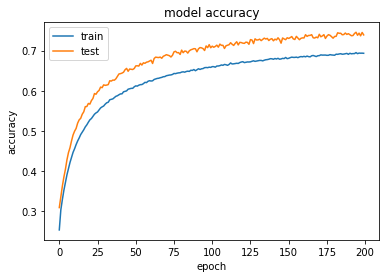

In [ ]:
import matplotlib.pyplot as plt
print(m.history.keys())
# summarize history for accuracy
# metrics=['acc',f1_m,precision_m, recall_m]
plt.plot(m.history['acc'])
plt.plot(m.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


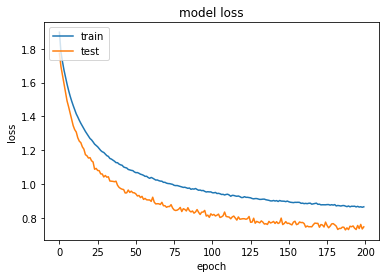

In [ ]:
# summarize history for loss
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

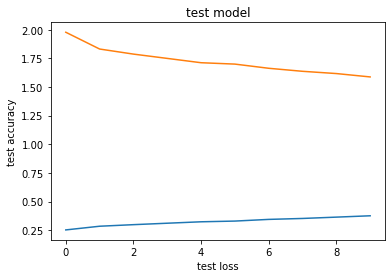

In [ ]:
plt.plot(m.history['val_accuracy'])
plt.plot(m.history['val_loss'])
plt.title('test model')
plt.ylabel('test accuracy')
plt.xlabel('test loss')
plt.show()

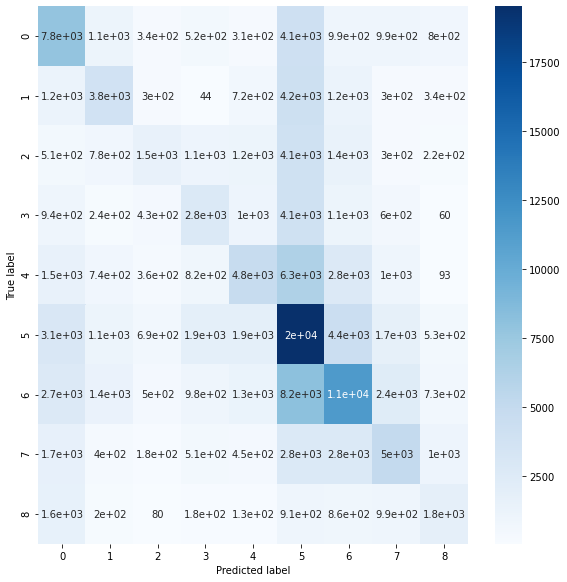

In [ ]:
y_pred=model.predict_classes(x_test)
from sklearn.metrics import confusion_matrix
import numpy as np
y_test=np.argmax(y_test, axis=1)
cmatrix=confusion_matrix(y_test, y_pred)
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(cmatrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()